# Predicting Car Price

## Introduction

In this notebook we aim to go through a toy example of an end-to-end data science project starting from collecting the data to model deployment. We follow the jupyter notebook [Car Price](https://github.com/PaacMaan/cars-price-predictor/blob/master/cars_price_predictor.ipynb) and the codes are taken from [Github codes](https://github.com/PaacMaan/cars-price-predictor/tree/master/flask_APP). We will build a regression model that can predict car prices based on multiple features such as mileage, mark, model, model_year, fuel_type and the city. We scrape data from the ad website [Avito](https://www.avito.ma/). The notebook will be presented as follows.

* Data collection
* Data preprocessing and cleaning
* Exploratory data analysis and visualization
* Data modeling
* Model deployment

All the codes are available on [Github](https://github.com/huanvo88/Projects/tree/master/car_price).

## Data collection

In [1]:
#data collection and preprocessing
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
plt.style.use('fivethirtyeight')

In [13]:
def get_ads_urls():
    urls_list = []
    #define the basic url
    basic_url = "https://www.avito.ma/fr/maroc/voitures-à_vendre?mpr=500000000&o="
    #loop over the pages 
    for i in range(1,250):
        #get the page url
        url = basic_url + str(i)
        #get the request response
        r = requests.get(url)
        data = r.text
        #transform it to a BeautifulSoup object
        soup = BeautifulSoup(data, "lxml")
        #get the links for the cars in a page
        for div in soup.findAll('div',{'class':'item-img'}):
            a = div.findAll('a')[0] 
            urls_list.append(a.get('href'))
    
    #write the link to a dataframe
    df = pd.DataFrame(data = {"url":urls_list})
    df.to_csv('ads_urls.csv', sep = ',', index = False)

In [14]:
#put all the urls in a file 
get_ads_urls()

In [68]:
def scrape_ad_data(ad_url):
    """Extract the information from each ad_url
    """
    r = requests.get(ad_url)
    data = r.text
    soup = BeautifulSoup(data, 'html.parser')
    feature = soup.findAll('h2',{'class':["font-normal" ,"fs12" ,"no-margin" ,"ln22"]})
    #create a list to hold the features
    results = []
    for a in feature:
        results.append(''.join(a.findAll(text = True)).replace('\n',''))
    return results    

In [44]:
import csv
def write_data_to_csv(data):
    with open("output.csv","w") as f:
        writer = csv.writer(f)
        writer.writerows(data)

In [69]:
#read in the url file 
url_data = pd.read_csv('ads_urls.csv', encoding = 'latin-1')
data = []
for i in range(len(url_data)):
    data.append(scrape_ad_data(url_data['url'][i]))

In [70]:
#write the results to file
write_data_to_csv(data)

## Data Preprocessing and Cleaning

In [162]:
#set the column names
colnames = ['price', 'year_model','mileage','fuel_type','mark','model','fiscal_power','sector','type','city']
#read in the csv file
df = pd.read_csv('output.csv', sep = ",", names = colnames, header = None, encoding = 'latin-1')
#display the first few rows
df.head()

,price,year_model,mileage,fuel_type,mark,model,fiscal_power,sector,type,city
0,50 000 DH,Année-Modèle:2007,Kilométrage:100 000 - 109 999,Type de carburant:Diesel,Marque:Volkswagen,Modèle:GOLF 2,Puissance fiscale:6 CV,-,"Type:Voitures, Offre",Oujda
1,100 000 DH,Année-Modèle:2008,Kilométrage:250 000 - 299 999,Type de carburant:Diesel,Marque:Honda,Modèle:CR-V,Puissance fiscale:8 CV,-,"Type:Voitures, Offre",Fès
2,59 000 DH,Année-Modèle:2007,Kilométrage:250 000 - 299 999,Type de carburant:Diesel,Marque:Ssangyong,Modèle:Rexton,Puissance fiscale:-,-,"Type:Voitures, Offre",Marrakech
3,47 000 DH,Année-Modèle:2005,Kilométrage:200 000 - 249 999,Type de carburant:Diesel,Marque:Citroen,Modèle:Berlingo,Puissance fiscale:-,-,"Type:Voitures, Offre",Casablanca
4,57 000 DH,Année-Modèle:2001,Kilométrage:25 000 - 29 999,Type de carburant:Diesel,Marque:Citroen,Modèle:C5,Puissance fiscale:6 CV,-,"Type:Voitures, Offre",Tétouan


### The 'price' column

In [163]:
#remove the rows that don't contain price
df = df[df['price'].str.contains('DH') == True]
#remove the string 'DH' from the price
df['price'] = df['price'].apply(lambda x:x.strip('DH'))
#remove the space 
df['price'] = df['price'].apply(lambda x:x.replace(" ",""))
#convert to numeric type
df['price'] = pd.to_numeric(df['price'],errors = "coerce")
#check the head
df['price'].head()

0    50000 
1    100000
2    59000 
3    47000 
4    57000 
Name: price, dtype: int64

In [164]:
#convert to USD
df['price'] = df['price']*0.27

### The 'year model' column

In [165]:
df['year_model'].value_counts()

Année-Modèle:2013                   485
Année-Modèle:2014                   464
Année-Modèle:2008                   459
Année-Modèle:2012                   444
Année-Modèle:2011                   426
Année-Modèle:2007                   419
Année-Modèle:2010                   412
Année-Modèle:2009                   403
Année-Modèle:2015                   386
Année-Modèle:2006                   331
Année-Modèle:2016                   279
Année-Modèle:2005                   266
Année-Modèle:2003                   248
Année-Modèle:2002                   231
Année-Modèle:2000                   192
Année-Modèle:2004                   191
Année-Modèle:2001                   189
Année-Modèle:1999                   172
Année-Modèle:2017                   172
Année-Modèle:1998                   124
Année-Modèle:1997                   122
Année-Modèle:1996                   115
Année-Modèle:2018                   103
Année-Modèle:1994                   94 
Année-Modèle:-                      92 


In [166]:
#remove the rows that don't contain Modele
df = df[df['year_model'].str.contains("Année-Modèle") == True]
#remove the Annee-Modele
df['year_model'] = df['year_model'].apply(lambda x:x.strip("Année-Modèle:"))
#remove the ou plus ancien
df['year_model'] = df['year_model'].apply(lambda x:x.strip(" ou plus ancien"))
#remove the row that contains -
df = df[df['year_model'] != '-']
#convert to integer
df['year_model'] = pd.to_numeric(df['year_model'], errors = 'coerce')
#check the values again
df['year_model'].value_counts()

2013.0    485
2014.0    464
2008.0    459
2012.0    444
2011.0    426
2007.0    419
2010.0    412
2009.0    403
2015.0    386
2006.0    331
2016.0    279
2005.0    266
2003.0    248
2002.0    231
2000.0    192
2004.0    191
2001.0    189
1999.0    172
2017.0    172
1998.0    124
1997.0    122
1996.0    115
2018.0    103
1994.0    94 
1992.0    90 
1995.0    86 
1991.0    76 
1993.0    76 
1987.0    73 
1986.0    66 
1990.0    66 
1988.0    60 
1989.0    59 
1985.0    51 
1984.0    39 
1980.0    23 
1983.0    20 
1982.0    17 
1981.0    16 
Name: year_model, dtype: int64

### The 'mileage' column

In [167]:
df['mileage'].value_counts()

Kilométrage:200 000 - 249 999     711
Kilométrage:100 000 - 109 999     398
Kilométrage:250 000 - 299 999     332
Kilométrage:140 000 - 149 999     326
Kilométrage:120 000 - 129 999     321
Kilométrage:190 000 - 199 999     321
Kilométrage:0 - 4 999             316
Kilométrage:150 000 - 159 999     308
Kilométrage:180 000 - 189 999     291
Kilométrage:160 000 - 169 999     275
Kilométrage:130 000 - 139 999     274
Kilométrage:110 000 - 119 999     268
Kilométrage:170 000 - 179 999     255
Kilométrage:20 000 - 24 999       220
Kilométrage:15 000 - 19 999       209
Kilométrage:25 000 - 29 999       203
Kilométrage:5 000 - 9 999         193
Kilométrage:30 000 - 34 999       191
Kilométrage:95 000 - 99 999       171
Kilométrage:90 000 - 94 999       169
Kilométrage:10 000 - 14 999       167
Kilométrage:80 000 - 84 999       162
Kilométrage:70 000 - 74 999       156
Kilométrage:85 000 - 89 999       142
Kilométrage:300 000 - 349 999     137
Kilométrage:35 000 - 39 999       125
Kilométrage:

In [168]:
#remove those rows that do not contain Kilometrage
df = df[df['mileage'].str.contains('Kilométrage')==True]
#remove Kilometrage
df['mileage'] = df['mileage'].apply(lambda x:x.strip('Kilométrage:'))
#remove the row with '-'
df = df[df['mileage'] != '-']
#replace 'Plus de 500 000' with '500000-500000'
df['mileage'] = df['mileage'].apply(lambda x:x.replace('Plus de 500 000',"500000-500000"))
#split into min and max value 
df['min'] = df['mileage'].apply(lambda x:x.split('-')[0])
df['max'] = df['mileage'].apply(lambda x:x.split('-')[1])
#remove empty space
df['min'] = df['min'].apply(lambda x:x.replace(" ",""))
df['max'] = df['max'].apply(lambda x:x.replace(" ",""))
#compute the mean 
df['mileage'] = df.apply(lambda row: (int(row['min'])+int(row['max']))/2, axis = 1)
#remove the min and max features
df.drop(['min','max'], axis = 1,inplace = True)
#count the values
df['mileage'].value_counts()

224999.5    711
104999.5    398
274999.5    333
144999.5    326
194999.5    321
124999.5    321
2499.5      316
154999.5    309
184999.5    292
164999.5    275
134999.5    274
114999.5    268
174999.5    256
22499.5     220
17499.5     209
27499.5     203
7499.5      193
32499.5     192
97499.5     172
92499.5     169
12499.5     167
82499.5     162
72499.5     156
87499.5     142
324999.5    137
37499.5     125
77499.5     112
62499.5     109
67499.5     108
52499.5     105
42499.5     103
47499.5     102
57499.5     91 
374999.5    64 
424999.5    50 
474999.5    32 
500000.0    22 
Name: mileage, dtype: int64

### The 'fuel_type' column

In [169]:
df['fuel_type'].value_counts()

Type de carburant:Diesel        5666
Type de carburant:Essence       1872
Type de carburant:Electrique    4   
Type de carburant:-             3   
Name: fuel_type, dtype: int64

In [170]:
#remove those rows that don't contain 'Type de carburant'
df = df[df['fuel_type'].str.contains("Type de carburant")==True]
#remove 'Type de carburant'
df['fuel_type'] = df['fuel_type'].apply(lambda x:x.strip("Type de carburant:"))
#remove '-'
df = df[df['fuel_type'] != '-']
#print values
df['fuel_type'].value_counts()

Diesel      5666
Ess         1872
Electriq    4   
Name: fuel_type, dtype: int64

### The 'mark' column

In [171]:
df['mark'].value_counts()

Marque:Renault           1155
Marque:Peugeot           900 
Marque:Volkswagen        891 
Marque:Dacia             582 
Marque:Mercedes-Benz     570 
Marque:Fiat              528 
Marque:Citroen           391 
Marque:Hyundai           334 
Marque:Ford              325 
Marque:BMW               229 
Marque:Toyota            225 
Marque:Honda             181 
Marque:Kia               174 
Marque:Audi              151 
Marque:Opel              102 
Marque:Nissan            99  
Marque:Seat              79  
Marque:Mitsubishi        76  
Marque:Suzuki            63  
Marque:Land Rover        59  
Marque:Chevrolet         52  
Marque:Alfa Romeo        45  
Marque:Skoda             43  
Marque:Ssangyong         33  
Marque:Volvo             31  
Marque:Jeep              27  
Marque:Mazda             22  
Marque:Daihatsu          21  
Marque:Autres            19  
Marque:mini              18  
Marque:Chery             18  
Marque:Daewoo            11  
Marque:Rover             11  
Marque:Por

In [172]:
#remove the rows that don't contain 'Marque'
df = df[df['mark'].str.contains('Marque')==True]
#remove 'Marque'
df['mark'] = df['mark'].apply(lambda x:x.strip('Marque:'))
#value counts
df['mark'].value_counts()

Renault         1155
Peugeot         900 
Volkswagen      891 
Daci            582 
cedes-Benz      570 
Fiat            528 
Citroen         391 
Hyundai         334 
Ford            325 
BMW             229 
Toyot           225 
Hond            181 
Ki              174 
Audi            151 
Opel            102 
Nissan          99  
Seat            79  
itsubishi       76  
Suzuki          63  
Land Rov        59  
Chevrolet       52  
Alfa Romeo      45  
Skod            43  
Ssangyong       33  
Volvo           31  
Jeep            27  
zd              22  
Daihats         21  
Autres          19  
mini            18  
Chery           18  
Daewoo          11  
Rov             11  
Porsch          10  
Isuz            8   
Jag             8   
serati          7   
Dodg            6   
Chrysl          5   
Infiniti        4   
Zoty            4   
Smart           4   
Iveco           3   
Humm            2   
Lincoln         2   
Ac              2   
BYD             2   
Changh       

### The 'model' column

In [173]:
df['model'].value_counts()

Modèle:Logan            316
Modèle:Clio             252
Modèle:Kangoo           226
Modèle:Megane           159
Modèle:Uno              157
Modèle:19               149
Modèle:GOLF 4           147
Modèle:220              136
Modèle:Fiesta           123
Modèle:Palio            115
Modèle:205              112
Modèle:Focus            112
Modèle:Polo             111
Modèle:Berlingo         109
Modèle:206              106
Modèle:Partner          99 
Modèle:Passat           97 
Modèle:Sandero          94 
Modèle:190              91 
Modèle:Classe C         86 
Modèle:Accent           83 
Modèle:Duster           82 
Modèle:Picanto          82 
Modèle:Dokker           79 
Modèle:Punto            73 
Modèle:309              70 
Modèle:Corolla          68 
Modèle:Accord           66 
Modèle:C4               63 
Modèle:Serie 3          63 
                        .. 
Modèle:PT Cruiser       1  
Modèle:Altima           1  
Modèle:SX4              1  
Modèle:Vitara           1  
Modèle:MDX          

In [174]:
#remove 'Modele'
df['model'] = df['model'].apply(lambda x:x.strip('Modèle:'))
#value_count
df['model'].value_counts()

Logan         316
Cli           252
Kang          226
gan           159
Un            157
19            149
GOLF 4        147
220           136
Fiesta        123
Pali          115
205           112
Focus         112
P             111
Berling       109
206           106
Partner       99 
Passat        97 
Sander        94 
190           91 
Classe C      86 
Accent        83 
Duster        82 
Picant        82 
Dokker        79 
Punt          73 
309           70 
Corolla       68 
Accor         66 
C4            63 
Serie 3       63 
              .. 
GT            1  
F1            1  
S5            1  
Ypsilon       1  
ACTY          1  
605           1  
Classe GL     1  
SPLASH        1  
Camar         1  
Classe CLK    1  
Altima        1  
TT            1  
Safran        1  
INTEGRA       1  
CARNIVAL      1  
ORION         1  
Brav          1  
K-GL          1  
500X          1  
Coup          1  
STAVIC        1  
NOTE          1  
Tourn         1  
FAMILY        1  
SX4       

### The 'fiscal power' column

In [175]:
df['fiscal_power'].value_counts()

Puissance fiscale:-                2964
Puissance fiscale:6 CV             1541
Puissance fiscale:8 CV             1167
Puissance fiscale:7 CV             817 
Puissance fiscale:9 CV             322 
Puissance fiscale:10 CV            181 
Puissance fiscale:5 CV             174 
Puissance fiscale:11 CV            156 
Puissance fiscale:12 CV            111 
Puissance fiscale:4 CV             25  
Puissance fiscale:13 CV            17  
Puissance fiscale:14 CV            13  
Puissance fiscale:17 CV            9   
Puissance fiscale:-                7   
Puissance fiscale:20 CV            6   
Puissance fiscale:18 CV            4   
Puissance fiscale:31 CV            4   
Puissance fiscale:16 CV            3   
Puissance fiscale: -               3   
Puissance fiscale:15 CV            3   
Puissance fiscale:27 CV            2   
Puissance fiscale:26 CV            2   
Puissance fiscale:Plus de 48 CV    2   
Puissance fiscale:24 CV            2   
Puissance fiscale:19 CV            1   


For this feature we will replace '-' by np.nan and fill in the missing values later.

In [201]:
#remove 'Puissance fiscale'
df['fiscal_power'] = df['fiscal_power'].apply(lambda x:x.strip('Puissance fiscale:'))
#replace 'Plus de 48 CV' by '48'
df['fiscal_power'] = df['fiscal_power'].apply(lambda x:x.replace('de 48 CV','48'))
#drop 'CV '
df['fiscal_power'] = df['fiscal_power'].apply(lambda x:x.strip(" CV"))
#convert to integer
df['fiscal_power'] = pd.to_numeric(df['fiscal_power'], errors = 'coerce')
#print values
df['fiscal_power'].value_counts()

6.0     1541
8.0     1167
7.0     817 
9.0     322 
10.0    181 
5.0     174 
11.0    156 
12.0    111 
4.0     25  
13.0    17  
14.0    13  
17.0    9   
20.0    6   
18.0    4   
31.0    4   
16.0    3   
15.0    3   
26.0    2   
24.0    2   
48.0    2   
27.0    2   
19.0    1   
28.0    1   
36.0    1   
37.0    1   
21.0    1   
29.0    1   
35.0    1   
Name: fiscal_power, dtype: int64

In [203]:
#missing value
df['fiscal_power'].isnull().sum()

2974

### Drop the 'sector' and 'type' columns

In [204]:
df.drop(['sector','type'],axis = 1,inplace = True)
df.head()

,price,year_model,mileage,fuel_type,mark,model,fiscal_power,city
0,13500.0,2007.0,104999.5,Diesel,Volkswagen,GOLF 2,6.0,Oujda
1,27000.0,2008.0,274999.5,Diesel,Hond,CR-V,8.0,Fès
2,15930.0,2007.0,274999.5,Diesel,Ssangyong,Rexton,NaN,Marrakech
3,12690.0,2005.0,224999.5,Diesel,Citroen,Berling,NaN,Casablanca
4,15390.0,2001.0,27499.5,Diesel,Citroen,C5,6.0,Tétouan


### Save the clean data set

In [205]:
df.to_csv('cars.csv',index = False)

## Exploratory Data Analysis and Visualization

In [2]:
df = pd.read_csv('cars.csv', encoding = 'latin-1')
print('The shape of the data is {}'.format(df.shape))
df.head()

The shape of the data is (7542, 8)


,price,year_model,mileage,fuel_type,mark,model,fiscal_power,city
0,13500.0,2007.0,104999.5,Diesel,Volkswagen,GOLF 2,6.0,Oujda
1,27000.0,2008.0,274999.5,Diesel,Hond,CR-V,8.0,Fès
2,15930.0,2007.0,274999.5,Diesel,Ssangyong,Rexton,NaN,Marrakech
3,12690.0,2005.0,224999.5,Diesel,Citroen,Berling,NaN,Casablanca
4,15390.0,2001.0,27499.5,Diesel,Citroen,C5,6.0,Tétouan


In [3]:
#missing values
df.isnull().sum()

price              0
year_model         0
mileage            0
fuel_type          0
mark               0
model              3
fiscal_power    2974
city               0
dtype: int64

In [4]:
#quick statistics
df.describe()

,price,year_model,mileage,fiscal_power
count,7.542000e+03,7542.000000,7542.000000,4568.000000
mean,2.614625e+04,2006.199814,127394.423230,7.540937
std,4.724152e+04,8.209124,91528.487476,2.391428
min,4.050000e+02,1980.000000,2499.500000,4.000000
25%,1.269000e+04,2002.000000,52499.500000,6.000000
50%,1.944000e+04,2008.000000,114999.500000,7.000000
75%,3.024000e+04,2013.000000,184999.500000,8.000000
max,2.835000e+06,2018.000000,500000.000000,48.000000


### Remove outliers

In [5]:
mean = np.mean(df['price'])
std = np.std(df['price'])
df = df[(df['price']>=mean-3*std)&(df['price']<=mean+3*std)]

### Price

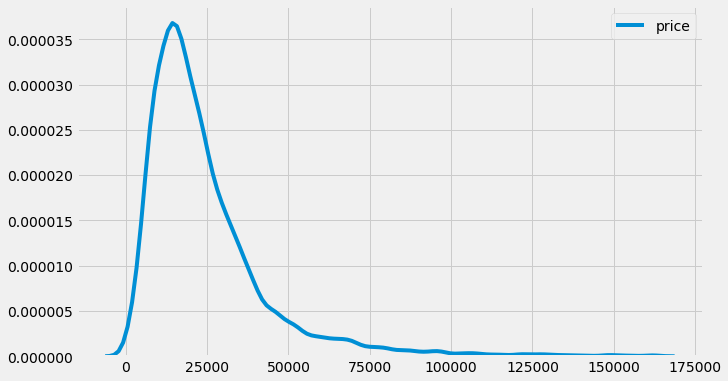

In [6]:
#distribution of the price 
plt.figure(figsize = (10,6))
sns.kdeplot(df['price'])

### Mileage

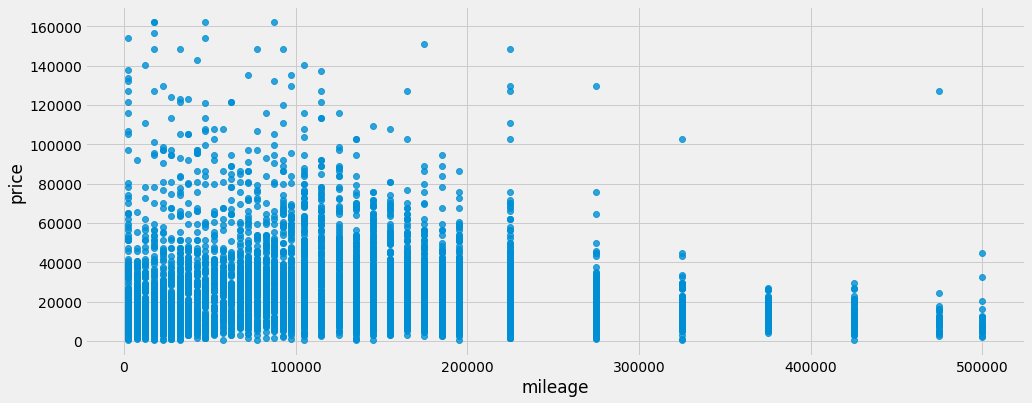

In [7]:
plt.figure(figsize = (15,6))
sns.regplot(x='mileage', y = 'price', data = df, fit_reg = False)

### Fuel Type

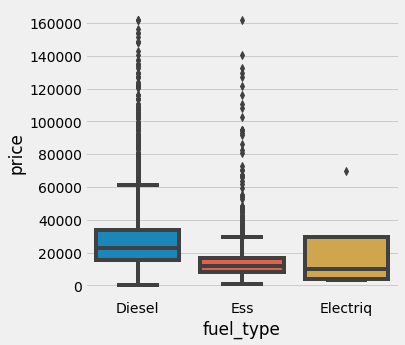

In [8]:
#box plot of price in terms of fuel type
plt.figure(figsize = (5,5))
sns.boxplot(x='fuel_type', y='price', data = df)

### Year_model

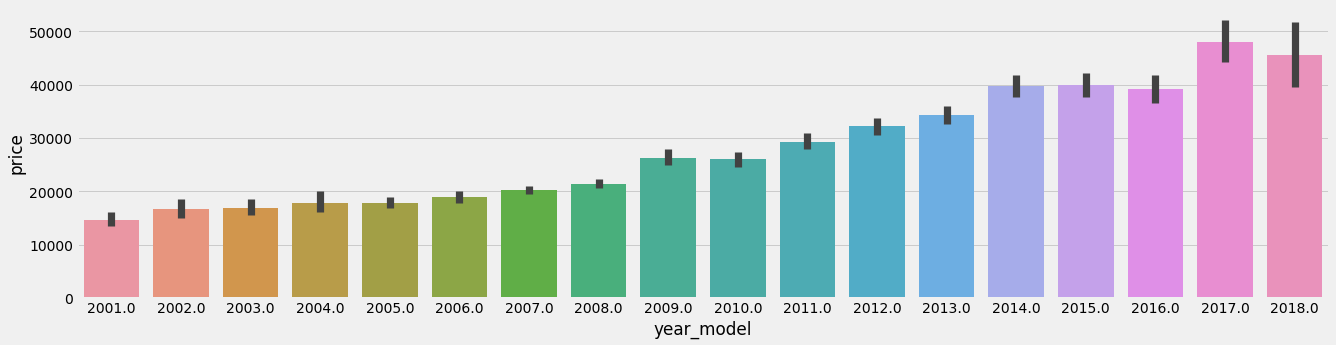

In [9]:
plt.figure(figsize = (20,5))
sns.barplot(x= 'year_model', y= 'price', data =df[df['year_model']>2000])

### Mark

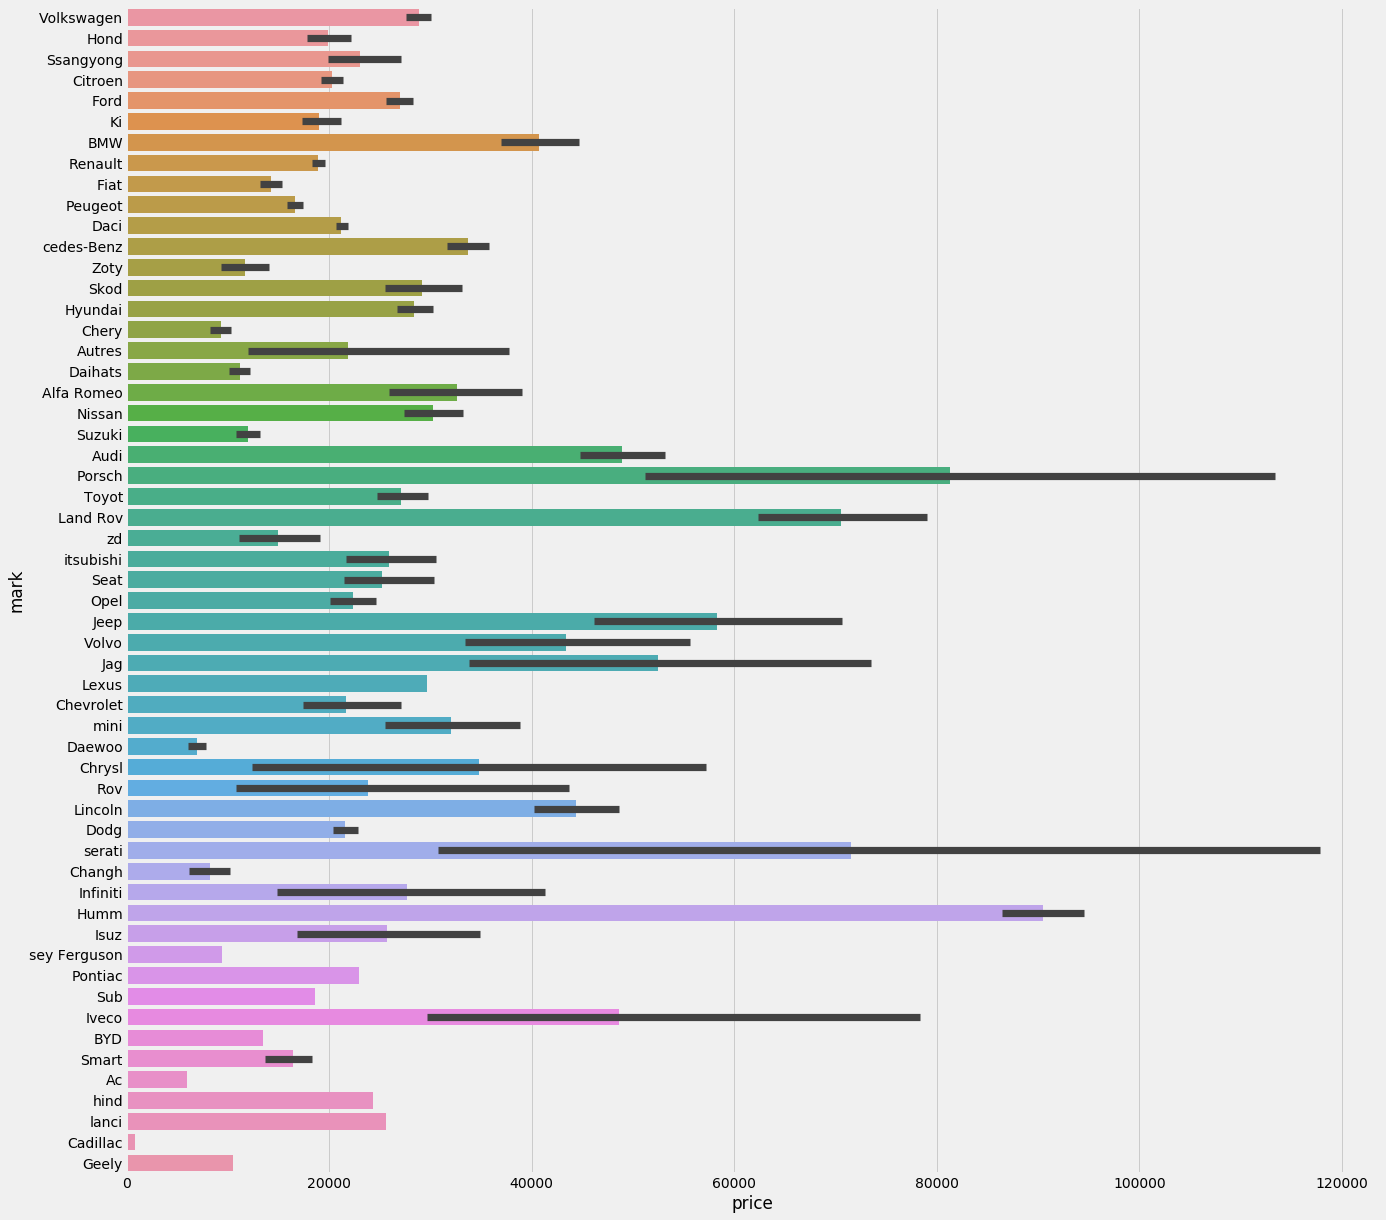

In [10]:
plt.figure(figsize = (20,20))
sns.barplot(x='price', y = 'mark', data = df)

### Fiscal power

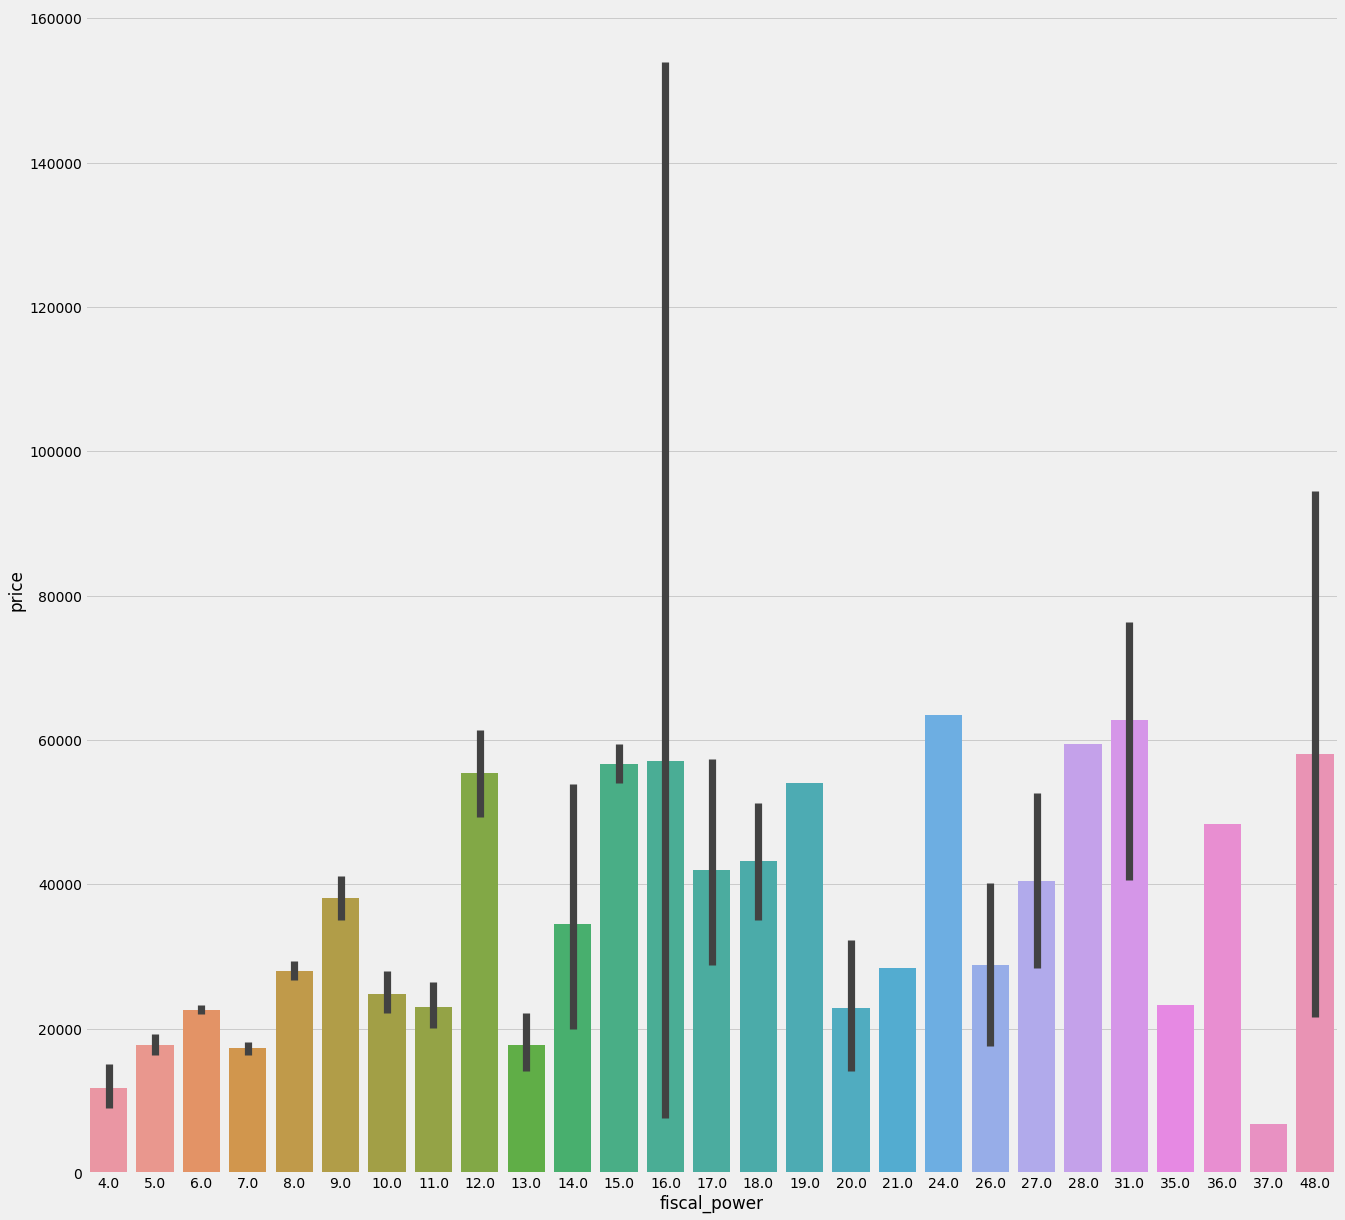

In [11]:
plt.figure(figsize = (20,20))
sns.barplot(x='fiscal_power', y='price', data = df)

### Correlation matrix

In [12]:
corr_matrix = df.corr()
corr_matrix['price'].sort_values(ascending = False)

price           1.000000
year_model      0.509601
fiscal_power    0.220533
mileage        -0.099845
Name: price, dtype: float64

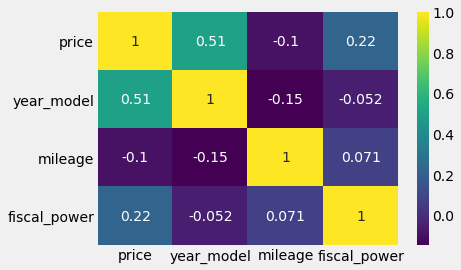

In [13]:
sns.heatmap(corr_matrix, annot = True, cmap = 'viridis')

## Data modeling

In [14]:
#pick the relevant features
X= df[['year_model','mileage','fiscal_power','fuel_type','mark']]
y = df['price']

### Imputation

In [15]:
from sklearn.preprocessing import Imputer

In [16]:
imputer = Imputer(strategy = 'mean')

In [17]:
imputer.fit(X[['fiscal_power']])

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [18]:
X.iloc[:,2] = imputer.transform(X[['fiscal_power']])[:,0]

D:\DataFile\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
X.isnull().sum()

year_model      0
mileage         0
fiscal_power    0
fuel_type       0
mark            0
dtype: int64

### Feature scaling

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()

In [22]:
scaler.fit(X[['year_model','mileage','fiscal_power']])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
X[['year_model','mileage','fiscal_power']]=scaler.transform(X[['year_model','mileage','fiscal_power']])

D:\DataFile\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\DataFile\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
X.head()

,year_model,mileage,fiscal_power,fuel_type,mark
0,0.101052,-0.246533,-8.353218e-01,Diesel,Volkswagen
1,0.222908,1.611046,2.607516e-01,Diesel,Hond
2,0.101052,1.611046,-4.867544e-16,Diesel,Ssangyong
3,-0.142661,1.064699,-4.867544e-16,Diesel,Citroen
4,-0.630087,-1.093371,-8.353218e-01,Diesel,Citroen


### One hot encode the categorical variables

In [25]:
X = pd.get_dummies(X)
print('The shape of the data is {}'.format(X.shape))
X.head()

The shape of the data is (7503, 62)


,year_model,mileage,fiscal_power,fuel_type_Diesel,fuel_type_Electriq,fuel_type_Ess,mark_Ac,mark_Alfa Romeo,mark_Audi,mark_Autres,...,mark_Volvo,mark_Zoty,mark_cedes-Benz,mark_hind,mark_itsubishi,mark_lanci,mark_mini,mark_serati,mark_sey Ferguson,mark_zd
0,0.101052,-0.246533,-8.353218e-01,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.222908,1.611046,2.607516e-01,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.101052,1.611046,-4.867544e-16,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.142661,1.064699,-4.867544e-16,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.630087,-1.093371,-8.353218e-01,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train test split

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('The training set size is {}'.format(X_train.shape))
print('The testing set size is {}'.format(X_test.shape))

The training set size is (6002, 62)
The testing set size is (1501, 62)


### Elastic net

In [28]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score

In [29]:
en = ElasticNet()
scores = cross_val_score(en, X, y, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-scores)
print('The mean rmse is {} with standard deviation {}'.format(np.mean(rmse_scores),np.std(rmse_scores)))

The mean rmse is 15610.890846542683 with standard deviation 904.3142469912567


### Random forest regressor

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
rdf = RandomForestRegressor()
scores = cross_val_score(rdf, X, y, scoring = 'neg_mean_squared_error', cv = 5)
rdf_score = np.sqrt(-scores)
print('The mean rmse of rdf is {} with standard deviation {}'.format(np.mean(rdf_score),np.std(rdf_score)))

The mean rmse of rdf is 12876.10682369192 with standard deviation 400.1337603464579


### Gradient boosting 

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
scores = cross_val_score(gbr, X, y, scoring = 'neg_mean_squared_error', cv = 5)
gbr_score = np.sqrt(-scores)
print('The mean rmse of gbr is {} with standard deviation {}'.format(np.mean(gbr_score),np.std(gbr_score)))

The mean rmse of gbr is 11600.40971045843 with standard deviation 380.25658994681504


In [43]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
print(gbr)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [44]:
from sklearn.metrics import mean_squared_error
predictions = gbr.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

11832.398463609816

## Predict an observation provided by a user

In [51]:
#user_input = [2012, 124999.5,6, 'Diesel','BMW']
user_input = {'year_model':2012, 'mileage':124999.5, 'fiscal_power':6, 'fuel_type':'Diesel', 'mark':'BMW'}
year_mean = np.mean(df['year_model'])
year_std = np.std(df['year_model'])
mileage_mean = np.mean(df['mileage'])
mileage_std = np.std(df['mileage'])
fiscal_mean = np.mean(df['fiscal_power'])
fiscal_std = np.std(df['fiscal_power'])

In [55]:
def input_to_one_hot(data):
    #initialize the target vector with zero values
    enc_input = np.zeros(62)
    enc_input[0] = (data['year_model']-year_mean)/year_std
    enc_input[1] = (data['mileage']-mileage_mean)/mileage_std
    enc_input[2] = (data['fiscal_power']-fiscal_mean)/fiscal_std
    #convert the mark to match the column name
    mark_col = 'mark_'+data['mark']
    #find the index of mark_col 
    mark_ind = X.columns.tolist().index(mark_col)
    #set the corresponding entry to be 1
    enc_input[mark_ind] = 1
    #convert the fuel type to match the column name
    fuel_col = 'fuel_type_'+data['fuel_type']
    #find the index of fuel_col
    fuel_ind = X.columns.tolist().index(fuel_col)
    #set the corresponding entry to be 1
    enc_input[fuel_ind] = 1
    return enc_input

In [56]:
input_to_one_hot(user_input)

array([ 0.71033426, -0.02799456, -0.65006306,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [57]:
a = input_to_one_hot(user_input)

In [64]:
print('The price of the car is {}'.format(round(gbr.predict([a])[0],2)))

The price of the car is 44334.74


### Save the model

In [65]:
from sklearn.externals import joblib

joblib.dump(gbr,'model.pkl')

['model.pkl']

## Model deployment

We will deploy the model using the Heroku platform. One can check out the app in action in [car-price-prediction](http://car-price-prediction-demo-2.herokuapp.com/). All the codes are available on [Github](https://github.com/huanvo88/Projects/tree/master/car_price).